In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4

# How to produce one ghost ?

In [3]:
import batoid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math

In [4]:
# Loading LSST geometry
# Also, you can change the filter (replace the g by i, r, u, y or z, for others see the batoid documentation)
telescope = batoid.Optic.fromYaml("LSST_g.yaml")

for surface in telescope.itemDict.values():
    if isinstance(surface, batoid.RefractiveInterface):
        surface.forwardCoating = batoid.SimpleCoating(0.02, 0.98)
        surface.reverseCoating = batoid.SimpleCoating(0.02, 0.98)
    if isinstance(surface, batoid.Detector):
        surface.forwardCoating = batoid.SimpleCoating(0.30, 0.70)

In [5]:
# Initialise theta_x and theta_y as you want
theta_x = 1.0
theta_y = 1.0

In [6]:
# Start the calculus
rays = batoid.RayVector.asPolar(
        telescope, wavelength=620e-9,
        theta_x=np.deg2rad(theta_x), theta_y=np.deg2rad(theta_y),
        naz=1000, nrad=300, flux=1.0
    )
rForward, rReverse = telescope.traceSplit(rays, minFlux=1e-4)

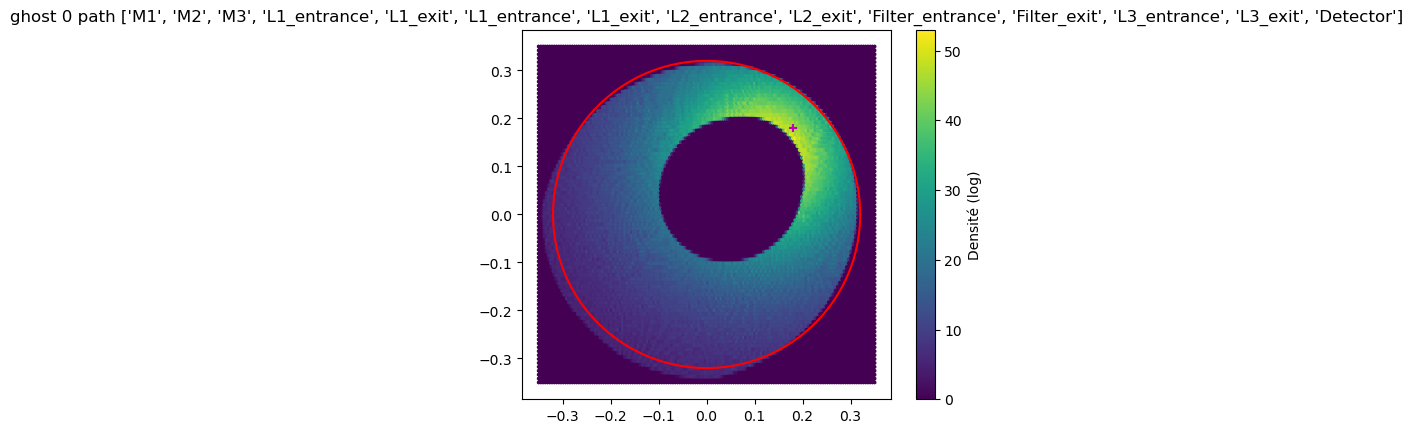

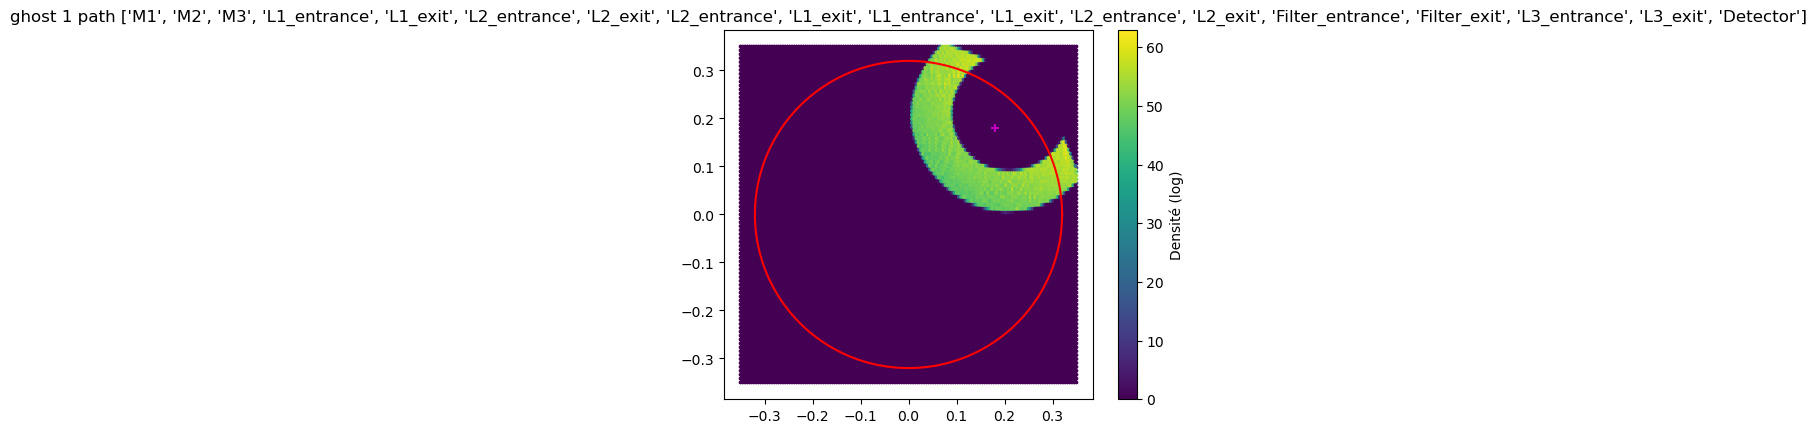

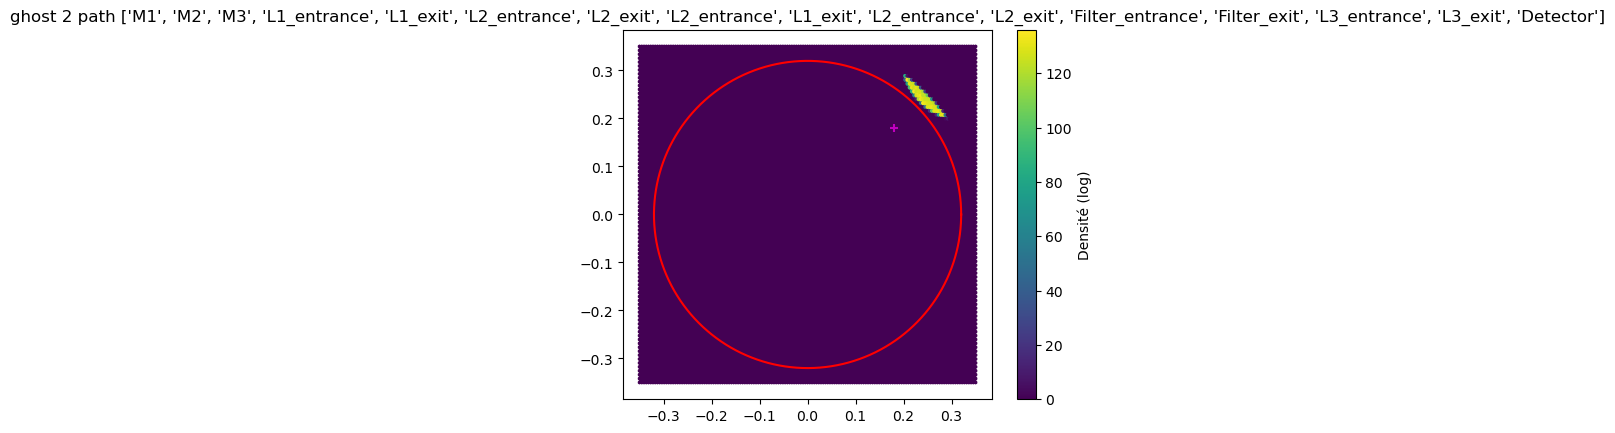

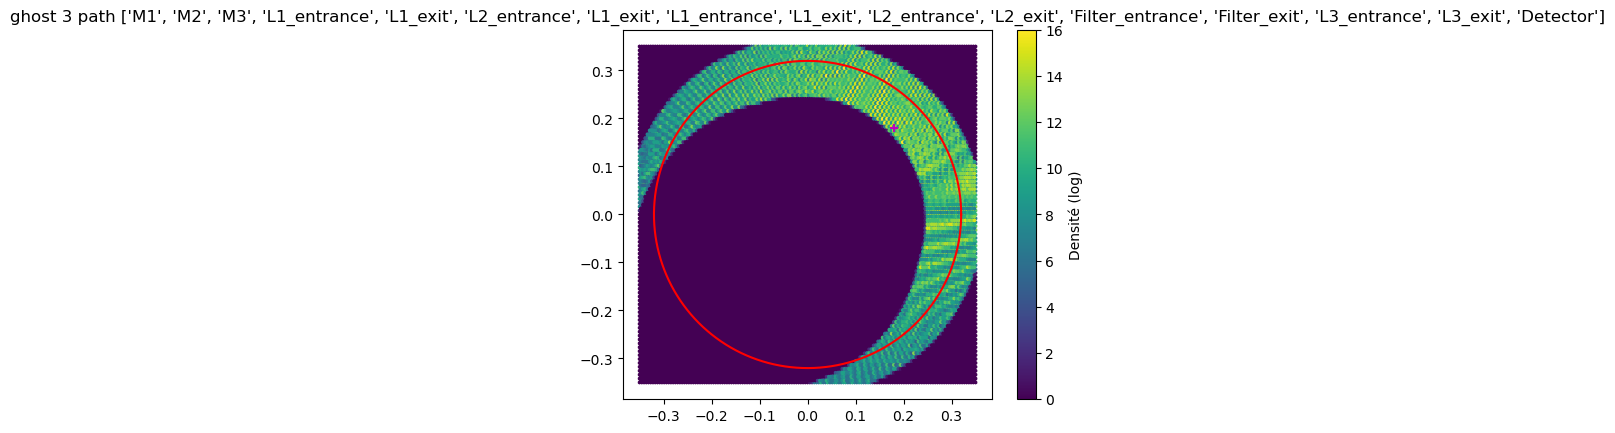

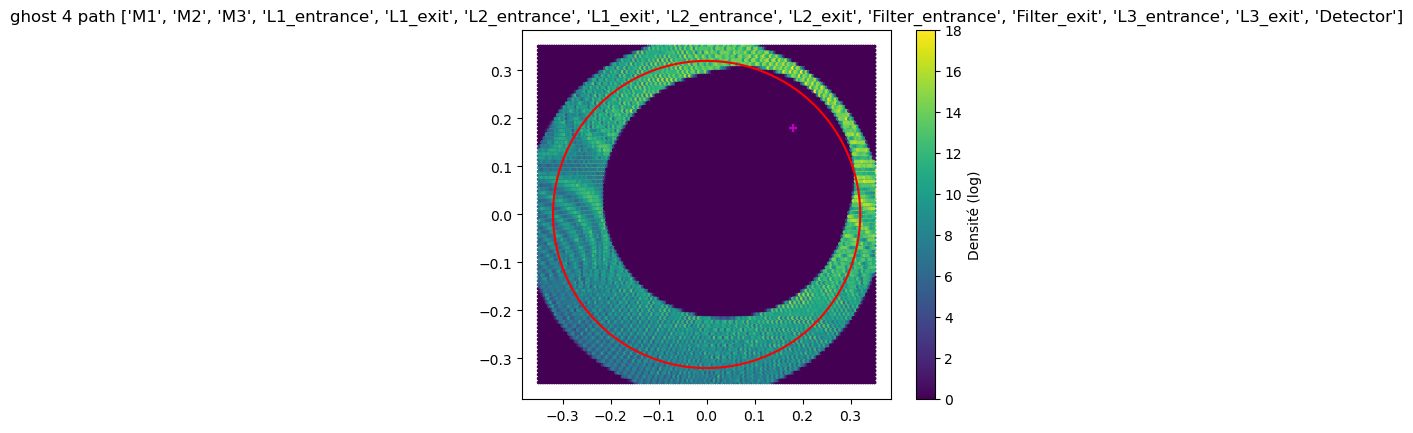

In [7]:
# Plot first n ghost
n = 5

for i, rr in enumerate(rForward[:n]):
    hb = plt.hexbin(rr.x, rr.y, extent=[-0.35, 0.35, -0.35, 0.35], gridsize=150)
    # plot approximate focal plane radius
    th = np.linspace(0, 2*np.pi, 1000)
    plt.plot(0.32*np.cos(th), 0.32*np.sin(th), c='r')
    # plot direct path location on focal plane
    # direct path will be rForward with fewest number of things in "path"
    w = np.argmin([len(rrr.path) for rrr in rForward])
    plt.scatter(np.mean(rForward[w].x), np.mean(rForward[w].y), marker='+', color='m')
    plt.gca().set_aspect("equal")
    plt.colorbar(hb, label="Densité (log)")
    plt.title(f"ghost {i} path {rr.path}")
    plt.show()

# How to have all ghosts on a subplot ?

In [9]:
# Start by define a function to know how many rows and columns we need
def get_subplot_grid(num_subplots):
    """Retourne (n_rows, n_cols) pour organiser num_subplots en subplots équilibrés."""
    n_cols = math.ceil(math.sqrt(num_subplots))
    n_rows = math.ceil(num_subplots / n_cols)
    return n_rows, n_cols

In [10]:
# Take back their
nrows, ncols = get_subplot_grid(len(rForward))

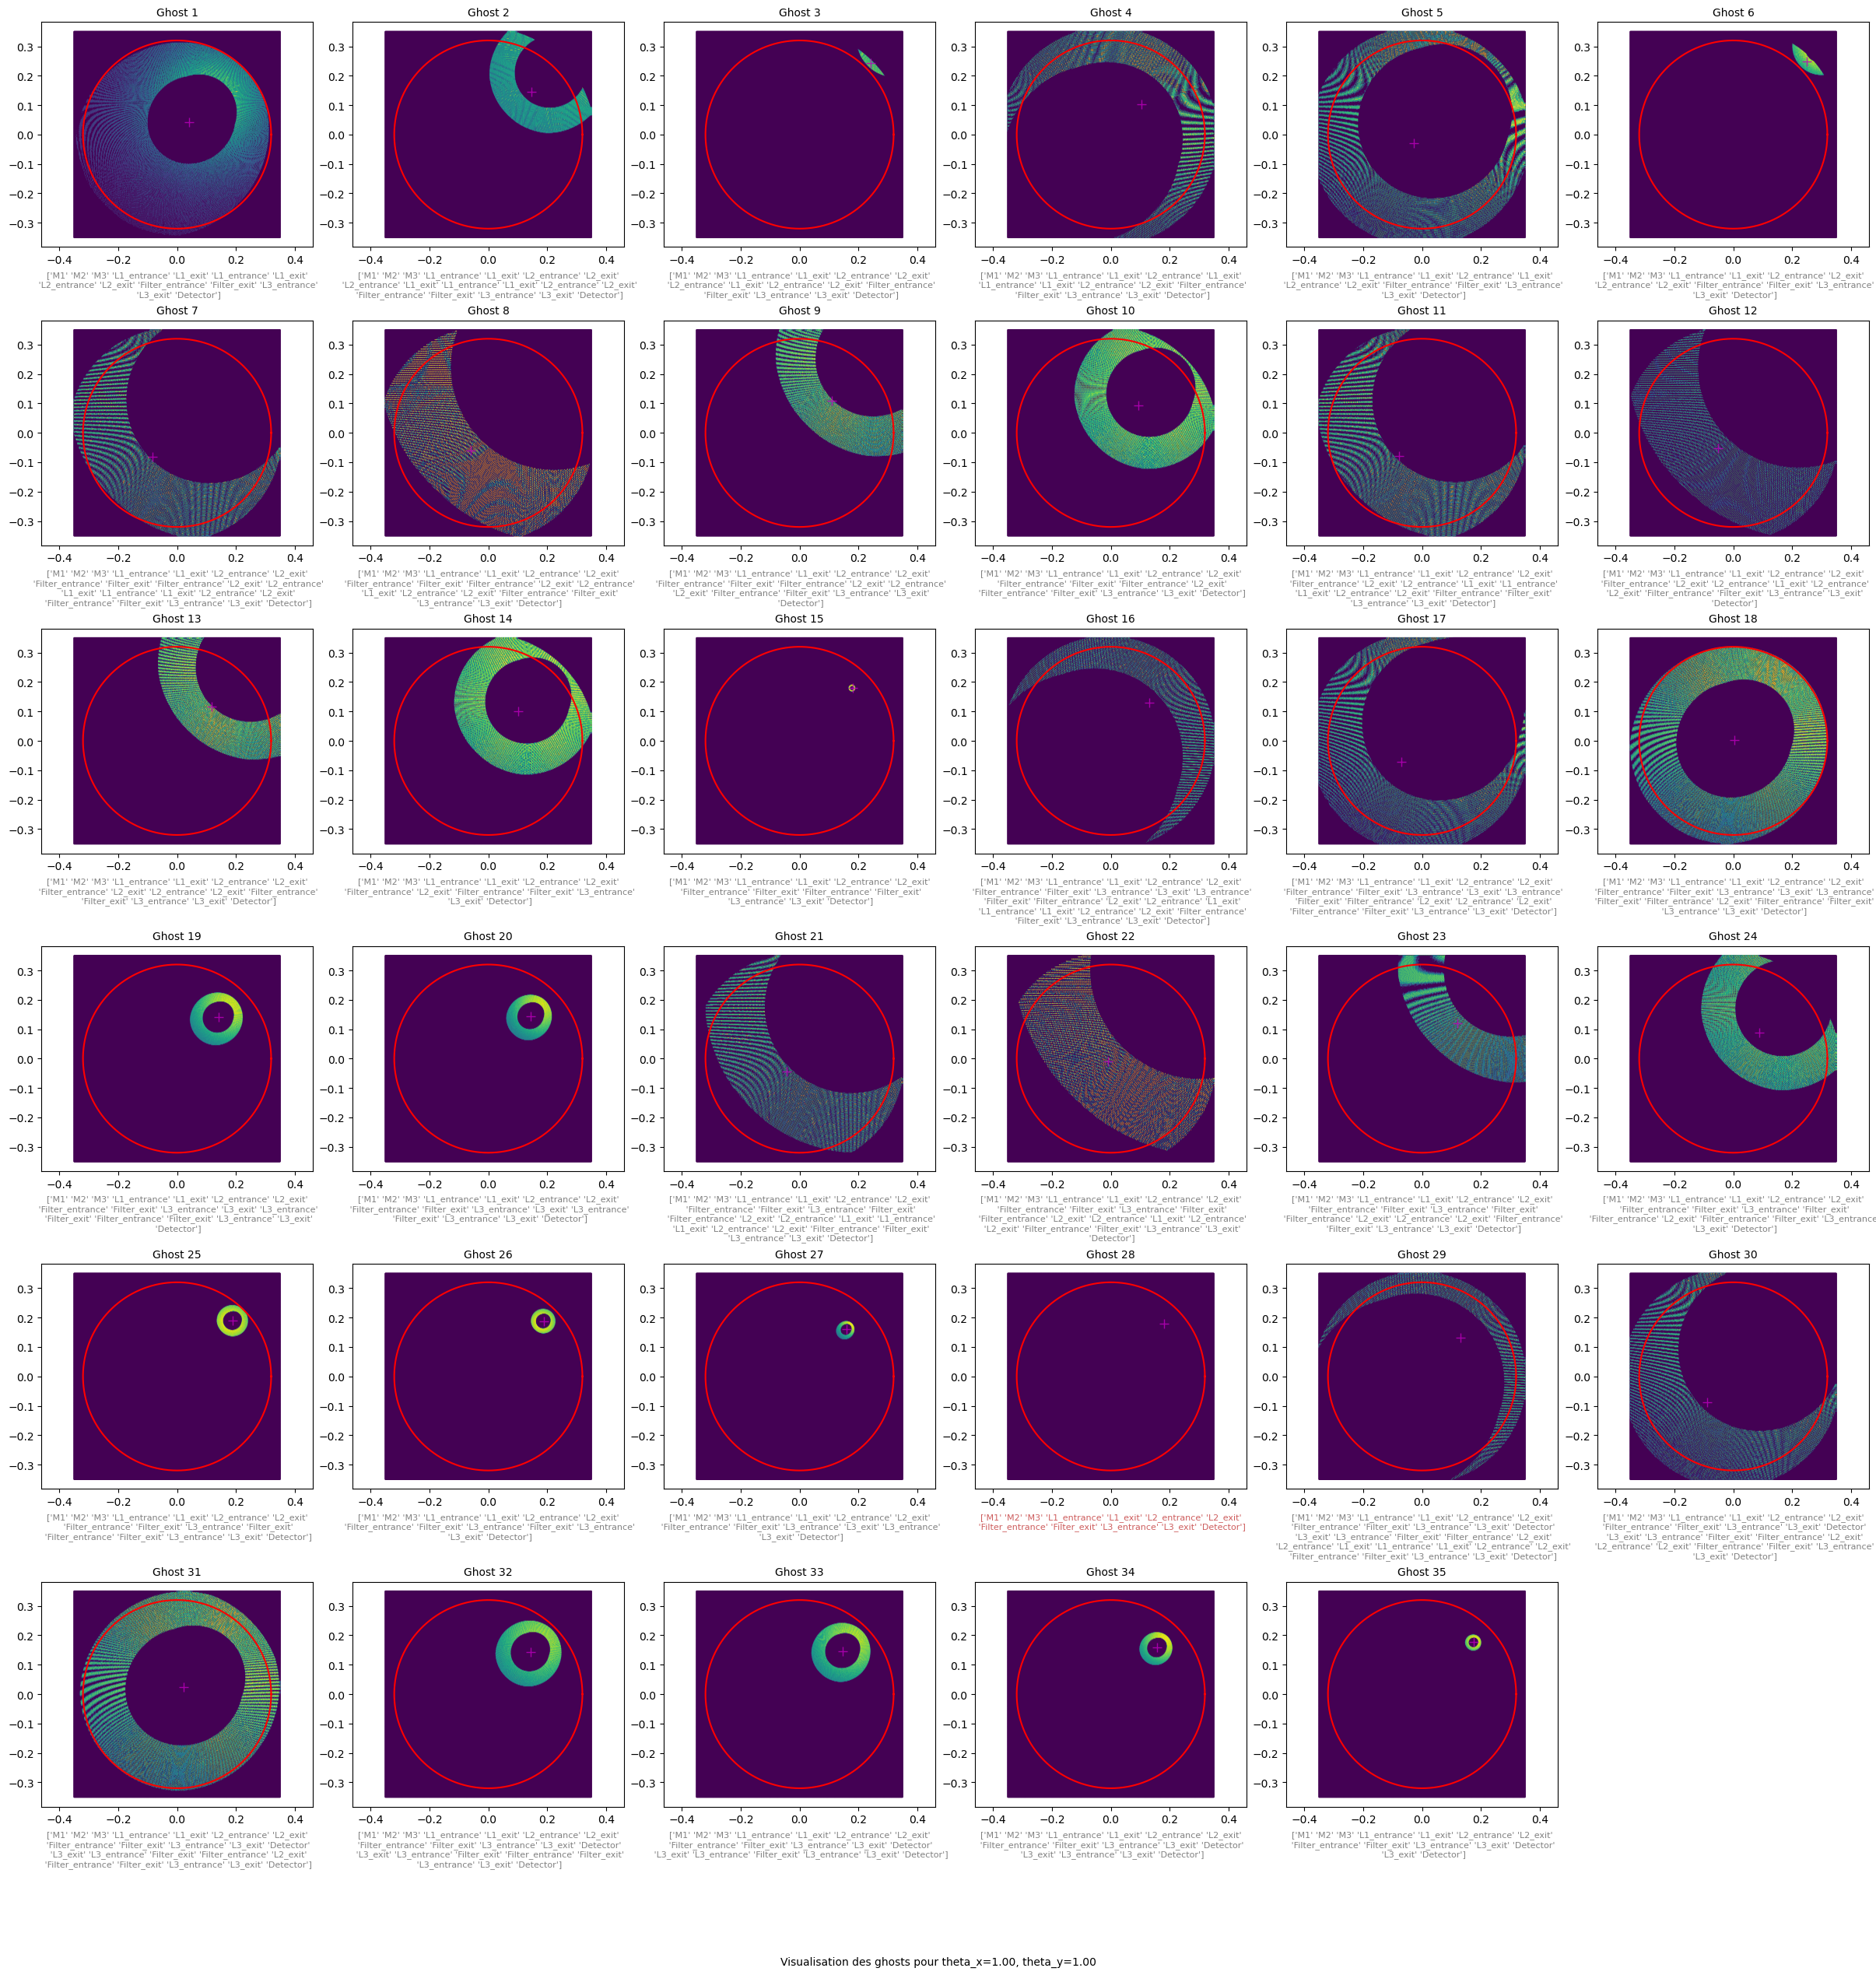

In [11]:
# Initialize subplot
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

if nrows == 1 or ncols == 1:
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
else:
    axes = np.array(axes).flatten()

hexbin_collection = [None] * len(rForward)

# Note the reference optic way
ref = ['M1', 'M2', 'M3', 'L1_entrance', 'L1_exit', 'L2_entrance', 'L2_exit', 'Filter_entrance', 'Filter_exit', 'L3_entrance', 'L3_exit', 'Detector']

# Add the data
for i in range(len(rForward)):
    hexbin_collection[i] = axes[i].hexbin(
        rForward[i].x, rForward[i].y, extent=[-0.35, 0.35, -0.35, 0.35],
        gridsize=500
    )
    th = np.linspace(0, 2*np.pi, 1000)
    axes[i].plot(0.32*np.cos(th), 0.32*np.sin(th), c='r', label="Cercle optique")
    mean_x, mean_y = np.mean(rForward[i].x), np.mean(rForward[i].y)
    axes[i].plot(mean_x, mean_y, marker='+', color='m', linestyle='None', markersize=8, alpha=0.8, label="Centre")
    if str(rForward[i].path) == str(ref):
        axes[i].set_xlabel(f"{np.array(rForward[i].path)}", fontsize=8, color="indianred", labelpad=5)
    else :
        axes[i].set_xlabel(f"{np.array(rForward[i].path)}", fontsize=8, color="gray", labelpad=5)
    axes[i].axis("equal")
    axes[i].set_title(f"Ghost {i+1}", fontsize=10)
    
# Mask empty plots
for i in range(len(rForward), len(axes)):
    axes[i].axis("off")

# Add a description under the figure
fig.text(0.5, -0.05, f"Visualisation des ghosts pour theta_x={theta_x:.2f}, theta_y={theta_y:.2f}", ha="center", fontsize=10)

plt.show()

# How to superpose all ghosts ?

In [13]:
# First you need to fusion all x, y in one array
x_data = np.concatenate([rForward[i].x for i in range(len(rForward))])
y_data = np.concatenate([rForward[i].y for i in range(len(rForward))])

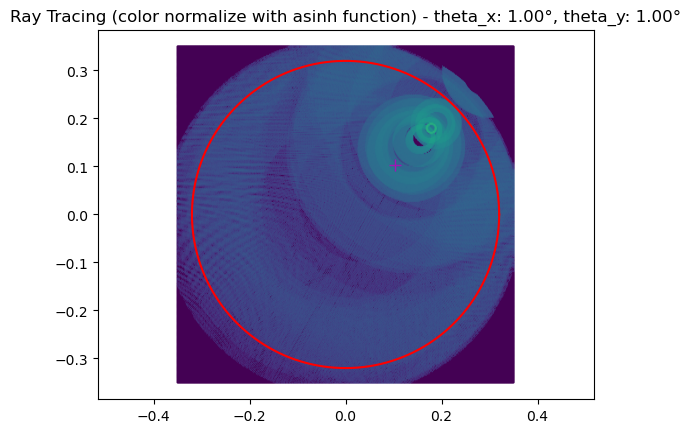

In [14]:
# And you can do it easily
hb = plt.hexbin(
    x_data, y_data, extent=[-0.35, 0.35, -0.35, 0.35],
    gridsize=500, norm=colors.AsinhNorm()
)
th = np.linspace(0, 2*np.pi, 1000)
plt.plot(0.32*np.cos(th), 0.32*np.sin(th), c='r', label="Cercle optique")
mean_x, mean_y = np.mean(x_data), np.mean(y_data)
plt.plot(mean_x, mean_y, marker='+', color='m', linestyle='None', markersize=8, alpha=0.8, label="Centre")

plt.axis("equal")
plt.title(f"Ray Tracing (color normalize with asinh function) - theta_x: {theta_x:.2f}°, theta_y: {theta_y:.2f}°")
plt.show()

# How to get the profil along the position of the cross ?

In [16]:
# First you need hexbin's data
counts = hb.get_array()
verts = hb.get_offsets()

# And you select interesting data in an interval along mean of the other axe
interval = 0.02

x_bins = verts[:, 0][np.isclose(verts[:, 1], mean_y, atol=interval)]
x_counts = counts[np.isclose(verts[:, 1], mean_y, atol=interval)]
    
y_bins = verts[:, 1][np.isclose(verts[:, 0], mean_x, atol=interval)]
y_counts = counts[np.isclose(verts[:, 0], mean_x, atol=interval)]

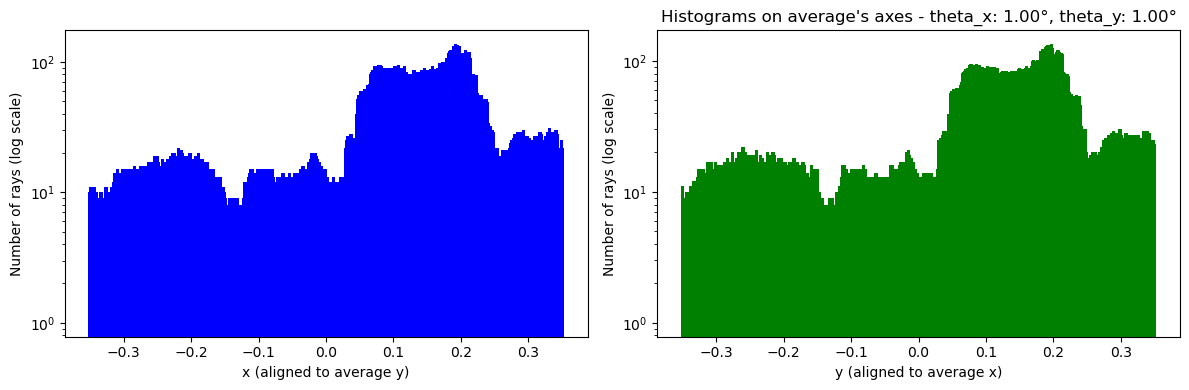

In [33]:
# And you do another subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(x_bins, x_counts, width=0.005, color='blue')
ax[0].set_yscale('log')
ax[0].set_xlabel("x (aligned to average y)")
ax[0].set_ylabel("Number of rays (log scale)")

ax[1].bar(y_bins, y_counts, width=0.005, color='green')
ax[1].set_yscale('log')
ax[1].set_xlabel("y (aligned to average x)")
ax[1].set_ylabel("Number of rays (log scale)")

plt.title(f"Histograms on average's axes - theta_x: {theta_x:.2f}°, theta_y: {theta_y:.2f}°")
plt.tight_layout()
plt.show()

# Notes

## 1. Ghosts séparés
- Le path en rouge correspond au chemin de référence (rayon direct). Ce n'est pas un ghost mais l'image direct de l'objet que l'on observe.
- On a besoin d'informations supplémentaires : afficher min, max et rms (std) dans le subtitle (Ghost n : min = ..., max = ..., rms = ...).
- A ce moment là on pourra décrire qualitativement les ghosts.

## 2. Ghosts superposés
- See animation's notebook

## 3. Histogrammes
- See animation's notebook